## Multiclass Hinge Loss

$$
\begin{align}
    F(X) &= \frac{1}{m}\sum_{i=1}^{m} \max_{j\ne l_i} [1+ \langle a_i, x_j - x_{l_i} \rangle]_+ \\
    f(X;a,l) &= \max_{j\ne l} [1+ \langle a, x_j - x_{l} \rangle]_+
\end{align}
$$

We will use subgradient of $f(X;a,l)$ because $f(X;a,l)$ is not differentiable.

Let
$$
    \nabla f(X;a,l) = \begin{bmatrix}\mathbf{0} & \cdots &\mathbf{a} &\cdots & -\mathbf{a} & \cdots & \mathbf{0} \end{bmatrix} = \mathbf{a}\mathbf{v}^T
$$
for a vector $\mathbf{v} \in \mathbb{R}^K$ s.t.
$$
v_i = \begin{cases}
1, &i=\min\{j:[1+ \langle a, x_j - x_{l} \rangle]_+ = \max_{j\ne l} [1+ \langle a, x_j - x_{l} \rangle]_+\} \\
-1, &i = l \\
0, &\text{o.w.}
\end{cases}
$$

Then $\nabla f(X;a,l) \in \partial f(X;a,l)$.

In [1]:
# libraries

using LinearAlgebra
using SparseArrays
using Random
using RandomMatrices
using StatsBase
using Statistics
using Plots

# No noise

In [2]:
# Data generation
Random.seed!(1224)

m, n, K, p = 2000, 7, 3, 0.01
A = randn(m,n) # generate data
U = randn(n,K) # generate optimal classifier
x0 = ones(n,K)

label = findmax(A*U,dims=2)[2]
label = getindex.(label,2)
label = vec(label) # generate label from optimal classifier

perm = sortperm(label) # permutation to sort label from 1 to K
label[:] = label[perm] # sort label
A[:,:] = A[perm,:] # align data according to the label

table = countmap(label)

# elongate matrix
E = zeros(K,0)
for i = 1:K
    temp = zeros(K,table[i])
    temp[i,:] .= 1
    E = [E temp]
end

# matrix to delete l_i th column
D = spzeros(0,K)
for i = 1:K
    temp = spzeros(table[i],K)
    temp[:,i] .= -Inf
    D = [D; temp]
end

#resamp = findall(x->x==1,Int.(rand(m) .< p)) # choose label to add noise
#label[resamp] = rand(1:K,length(resamp)) # uniform resampling
#length(resamp)

In [3]:
function F(X) # input is a vector
    X = reshape(X,n,K) # reshape into matrix
    aixli = sum(A .* (X*E)', dims=2) # vector of dot products a_i, X_l_i
    res = ones(m,K) + A*X - Diagonal(vec(aixli))*ones(m,K) # 1 + dot(a_i, X_j - X_l_i)
    res = max.(res,0) + D # Hinge loss and ignore the l_i th column
    res = findmax(res,dims=2)[1] # find row-wise max
    res = mean(res) # empirical mean
    return res
end

F (generic function with 1 method)

In [4]:
function eval(X,idx) # calculate hinge loss and its gradient at X given idx th sample # input is a vector
    X = reshape(X,n,K) # reshape into matrix
    a = A[idx,:]
    l = label[idx]
    res = a'*(X[:,setdiff(1:K,l)].- X[:,l])
    res = vec(res) .+ 1
    res = max.(res,0)
    f, res = findmax(res)
    if f > 0
        v = zeros(K)
        v[res] = 1
        v[l] = -1
        ∇f = a*v'
        ∇f = vec(∇f)
    else
        ∇f = zeros(n*K)
    end
    return f, ∇f
end

eval (generic function with 2 methods)

In [5]:
optval = F(U)

0.1358185589720092

## SGM

In [6]:
# parameter setting
nsim = 100 # # of simulation
nitr = 2e3 # total iterations
γinits = 10 .^ (-2:0.5:5)
ϵ = 0.05 # tolerance
iterations_SGM = nitr*ones(nsim,length(γinits))

# main iteration
for i = 1:length(γinits)
    for j = 1:nsim
        # initialize X0
        x = vec(x0)
        γinit = γinits[i]
        for k = 1:nitr
            idx = sample(1:m) # sampling
            γ = γinit * k^(-0.6) # update stepsize
            
            fx ,∇fx = eval(x,idx)
            if ∇fx == zeros(n*K)
                continue
            end
            x -= γ*∇fx
            
            if (abs(F(x) - optval) <= ϵ )
                iterations_SGM[j, i] = k
                break
            end
        end
    end
    print(i)
end

123456789101112131415

In [7]:
sgm_iters = [[quantile(iterations_SGM[:,i], 0.05) for i = 1:15] median(iterations_SGM, dims = 1)' [quantile(iterations_SGM[:,i], 0.95) for i = 1:15]]

15×3 Array{Float64,2}:
 2000.0   2000.0  2000.0 
 2000.0   2000.0  2000.0 
 2000.0   2000.0  2000.0 
  812.8   1158.0  1560.85
  151.8    266.5   616.4 
  151.9    386.0   845.95
  320.85   631.0  2000.0 
  536.85  1282.5  2000.0 
  743.8   2000.0  2000.0 
 1962.45  2000.0  2000.0 
 2000.0   2000.0  2000.0 
 2000.0   2000.0  2000.0 
 2000.0   2000.0  2000.0 
 2000.0   2000.0  2000.0 
 2000.0   2000.0  2000.0 

## truncated method

In [8]:
iterations_truncated = nitr*ones(nsim,length(γinits))

# main iteration
for i = 1:length(γinits)
    for j = 1:nsim
        # initialize X0
        x = randn(n*K)
        γinit = γinits[i]
        for k = 1:nitr
            idx = sample(1:m) # sampling
            γ = γinit * k^(-0.6) # update stepsize
            
            fx ,∇fx = eval(x,idx)
            if ∇fx == zeros(n*K)
                continue
            end
            x -= min(γ, fx/sum(abs2,∇fx))*∇fx
            
            if (abs(F(x) - optval) <= ϵ)
                iterations_truncated[j, i] = k
                break
            end
        end
    end
    print(i)
end

123456789101112131415

In [9]:
trunc_iters = [[quantile(iterations_truncated[:,i], 0.05) for i = 1:15] median(iterations_truncated, dims = 1)' [quantile(iterations_truncated[:,i], 0.95) for i = 1:15]]

15×3 Array{Float64,2}:
 2000.0   2000.0  2000.0 
 2000.0   2000.0  2000.0 
 2000.0   2000.0  2000.0 
 1206.25  2000.0  2000.0 
  201.0    402.5   655.45
  117.95   193.5   308.35
  111.0    180.5   305.35
  115.85   193.5   320.0 
  114.45   209.0   342.65
  104.8    185.5   318.95
  111.85   185.5   295.1 
  106.95   176.0   303.25
  108.95   185.5   327.8 
   98.85   182.0   306.4 
   95.75   178.5   278.2 

## bundle method

In [10]:
iterations_bundle = nitr*ones(nsim,length(γinits))

# main iteration
for i = 1:length(γinits)
    for j = 1:nsim
        # initialize X0
        x = randn(n*K)
        γinit = γinits[i]
        for k = 1:nitr
            idx = sample(1:m) # sampling
            γ = γinit * k^(-0.6) # update stepsize
            
            fx ,∇fx = eval(x,idx)
            if ∇fx == zeros(n*K)
                continue
            end
            y = x - γ*∇fx
            fy ,∇fy = eval(y,idx)
            x̄ = x - γ*∇fy
            if fx + ∇fx'*(x̄-x) <= fy + ∇fy'*(x̄-y)
                x = x̄
            else
                λ = (fy-fx+γ*sum(abs2,∇fx))/(γ*sum(abs2,∇fy-∇fx))
                x -= γ*( (1-λ)*∇fx + λ*∇fy  )
            end
            if (abs(F(x) - optval) <= ϵ)
                iterations_bundle[j, i] = k
                break
            end
        end
    end
    print(i)
end

123456789101112131415

In [11]:
bund_iters = [[quantile(iterations_bundle[:,i], 0.05) for i = 1:15] median(iterations_bundle, dims = 1)' [quantile(iterations_bundle[:,i], 0.95) for i = 1:15]]

15×3 Array{Float64,2}:
 2000.0   2000.0  2000.0 
 2000.0   2000.0  2000.0 
 2000.0   2000.0  2000.0 
 2000.0   2000.0  2000.0 
 2000.0   2000.0  2000.0 
 2000.0   2000.0  2000.0 
  110.75   195.0  2000.0 
   98.65   182.5   309.0 
  105.5    192.5   309.8 
  120.9    197.5   308.45
  109.4    188.5   315.15
   99.6    190.0   297.65
   93.95   189.5   304.25
  112.9    181.0   291.1 
  100.95   188.5   340.0 

## proximal methods

In [12]:
using Convex, Mosek

function mhl_prox(x, γ, idx)
    a = A[idx,:]
    l = label[idx]
    V = Variable(n,K)
    prob = minimize( max(maximum((vec(a'*(V[:,setdiff(1:K,l)] - V[:,l]*ones(K-1)')) + ones(K-1))),0) + 1/(2*γ)*sumsquares(vec(V)-x) )
    solve!(prob,MosekSolver(LOG=0))
    return vec(V.value)
end

┌ Info: Precompiling Mosek [6405355b-0ac2-5fba-af84-adbd65488c0e]
└ @ Base loading.jl:1242
ERROR: LoadError: ArgumentError: Package Mosek does not have MathProgBase in its dependencies:
- If you have Mosek checked out for development and have
  added MathProgBase as a dependency but haven't updated your primary
  environment's manifest file, try `Pkg.resolve()`.
- Otherwise you may need to report an issue with Mosek
Stacktrace:
 [1] require(::Module, ::Symbol) at ./loading.jl:889
 [2] include at ./boot.jl:328 [inlined]
 [3] include_relative(::Module, ::String) at ./loading.jl:1094
 [4] include(::Module, ::String) at ./Base.jl:31
 [5] top-level scope at none:2
 [6] eval at ./boot.jl:330 [inlined]
 [7] eval(::Expr) at ./client.jl:432
 [8] top-level scope at ./none:3
in expression starting at /DATA/home/ppinsm/.julia/packages/Mosek/vBHcL/src/Mosek.jl:279


ErrorException: Failed to precompile Mosek [6405355b-0ac2-5fba-af84-adbd65488c0e] to /DATA/home/ppinsm/.julia/compiled/v1.2/Mosek/vS2ln.ji.

In [13]:
iterations_proximal = nitr*ones(nsim,length(γinits))

# main iteration
for i = 1:length(γinits)
    for j = 1:nsim
        # initialize X0
        x = randn(n*K)
        γinit = γinits[i]
        for k = 1:nitr
            idx = sample(1:m) # sampling
            γ = γinit * k^(-0.6) # update stepsize
            
            x = mhl_prox(x, γ, idx)
            if (abs(F(x) - optval) <= ϵ)
                iterations_proximal[j, i] = k
                break
            end
        end
    end
    print(i)
end

UndefVarError: UndefVarError: mhl_prox not defined

In [14]:
prox_iters = [[quantile(iterations_proximal[:,i], 0.05) for i = 1:15] median(iterations_proximal, dims = 1)' [quantile(iterations_proximal[:,i], 0.95) for i = 1:15]]

15×3 Array{Float64,2}:
 2000.0  2000.0  2000.0
 2000.0  2000.0  2000.0
 2000.0  2000.0  2000.0
 2000.0  2000.0  2000.0
 2000.0  2000.0  2000.0
 2000.0  2000.0  2000.0
 2000.0  2000.0  2000.0
 2000.0  2000.0  2000.0
 2000.0  2000.0  2000.0
 2000.0  2000.0  2000.0
 2000.0  2000.0  2000.0
 2000.0  2000.0  2000.0
 2000.0  2000.0  2000.0
 2000.0  2000.0  2000.0
 2000.0  2000.0  2000.0

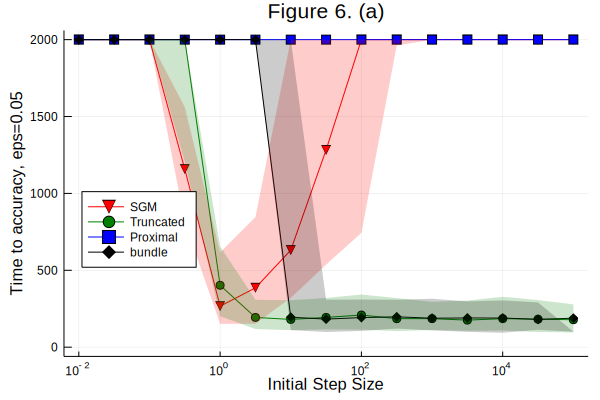

In [15]:
plt = plot(γinits, [sgm_iters[:,2] trunc_iters[:, 2] prox_iters[:, 2] bund_iters[:, 2]], 
    legend = :left,
    xscale = :log10,
    xlab = "Initial Step Size",
    ylab = "Time to accuracy, eps=0.05",
    title = "Figure 6. (a)",
    label = ["SGM" "Truncated" "Proximal" "bundle"],
    color = [:red :green :blue :black],
    markershape = [:dtriangle :circle :square :diamond],
    ylim = [0, nitr])
a = Shape([γinits; γinits[end:-1:2]],
    [sgm_iters[:,1]; sgm_iters[end:-1:2,3]])
plot!(a, fillalpha = 0.2, linecolor = nothing, fillcolor = :red, label = "")
b = Shape([γinits; γinits[end:-1:2]],
    [trunc_iters[:,1]; trunc_iters[end:-1:2,3]])
plot!(b, fillalpha = 0.2, linecolor = nothing, fillcolor = :green, label = "")
c = Shape([γinits; γinits[end:-1:2]],
    [prox_iters[:,1]; prox_iters[end:-1:2,3]])
plot!(c, fillalpha = 0.2, linecolor = nothing, fillcolor = :blue, label = "")
d = Shape([γinits; γinits[end-1:-1:2]],
    [bund_iters[:,1]; bund_iters[end-1:-1:2,3]])
plot!(d, fillalpha = 0.2, linecolor = nothing, fillcolor = :black, label = "")

# With Noise

In [16]:
# Data generation

resamp = findall(x->x==1,Int.(rand(m) .< p)) # choose label to add noise
label[resamp] = rand(1:K,length(resamp)) # uniform resampling

perm = sortperm(label) # permutation to sort label from 1 to K
label[:] = label[perm] # sort label
A[:,:] = A[perm,:] # align data according to the label

table = countmap(label)

# elongate matrix
E = zeros(K,0)
for i = 1:K
    temp = zeros(K,table[i])
    temp[i,:] .= 1
    E = [E temp]
end

# matrix to delete l_i th column
D = spzeros(0,K)
for i = 1:K
    temp = spzeros(table[i],K)
    temp[:,i] .= -Inf
    D = [D; temp]
end

In [17]:
optval = F(U)

0.163060536747686

## SGM

In [18]:
iterations_SGM = nitr*ones(nsim,length(γinits))

# main iteration
for i = 1:length(γinits)
    for j = 1:nsim
        # initialize X0
        x = randn(n*K)
        γinit = γinits[i]
        for k = 1:nitr
            idx = sample(1:m) # sampling
            γ = γinit * k^(-0.6) # update stepsize
            
            fx ,∇fx = eval(x,idx)
            if ∇fx == zeros(n*K)
                continue
            end
            x -= γ*∇fx
            
            if (abs(F(x) - optval) <= ϵ)
                iterations_SGM[j, i] = k
                break
            end
        end
    end
    print(i)
end

123456789101112131415

In [19]:
sgm_iters = [[quantile(iterations_SGM[:,i], 0.05) for i = 1:15] median(iterations_SGM, dims = 1)' [quantile(iterations_SGM[:,i], 0.95) for i = 1:15]]

15×3 Array{Float64,2}:
 2000.0   2000.0  2000.0 
 2000.0   2000.0  2000.0 
 2000.0   2000.0  2000.0 
 1191.3   2000.0  2000.0 
  208.3    471.0   973.35
  190.95   541.0  1584.1 
 1095.55  2000.0  2000.0 
 2000.0   2000.0  2000.0 
 2000.0   2000.0  2000.0 
 2000.0   2000.0  2000.0 
 2000.0   2000.0  2000.0 
 2000.0   2000.0  2000.0 
 2000.0   2000.0  2000.0 
 2000.0   2000.0  2000.0 
 2000.0   2000.0  2000.0 

## truncated method

In [20]:
iterations_truncated = nitr*ones(nsim,length(γinits))

# main iteration
for i = 1:length(γinits)
    for j = 1:nsim
        # initialize X0
        x = randn(n*K)
        γinit = γinits[i]
        for k = 1:nitr
            idx = sample(1:m) # sampling
            γ = γinit * k^(-0.6) # update stepsize
            
            fx ,∇fx = eval(x,idx)
            if ∇fx == zeros(n*K)
                continue
            end
            x -= min(γ, fx/sum(abs2,∇fx))*∇fx
            
            if (abs(F(x) - optval) <= ϵ)
                iterations_truncated[j, i] = k
                break
            end
        end
    end
    print(i)
end

123456789101112131415

In [21]:
trunc_iters = [[quantile(iterations_truncated[:,i], 0.05) for i = 1:15] median(iterations_truncated, dims = 1)' [quantile(iterations_truncated[:,i], 0.95) for i = 1:15]]

15×3 Array{Float64,2}:
 2000.0   2000.0  2000.0 
 2000.0   2000.0  2000.0 
 2000.0   2000.0  2000.0 
 1198.55  2000.0  2000.0 
  206.75   384.0   680.9 
  125.95   199.0   312.4 
  110.75   191.0   383.55
  107.85   217.0   488.7 
  119.0    221.0   482.6 
  103.0    200.0   475.85
  104.8    217.0   416.6 
  116.65   208.0   436.65
  105.7    230.0   468.0 
  116.85   217.5   411.1 
  118.15   203.5   473.7 

## bundle method

In [22]:
iterations_bundle = nitr*ones(nsim,length(γinits))

# main iteration
for i = 1:length(γinits)
    for j = 1:nsim
        # initialize X0
        x = randn(n*K)
        γinit = γinits[i]
        for k = 1:nitr
            idx = sample(1:m) # sampling
            γ = γinit * k^(-0.6) # update stepsize
            
            fx ,∇fx = eval(x,idx)
            if ∇fx == zeros(n*K)
                continue
            end
            y = x - γ*∇fx
            fy ,∇fy = eval(y,idx)
            x̄ = x - γ*∇fy
            if fx + ∇fx'*(x̄-x) <= fy + ∇fy'*(x̄-y)
                x = x̄
            else
                if ∇fy == ∇fy
                    continue
                end
                λ = (fy-fx+γ*sum(abs2,∇fx))/(γ*sum(abs2,∇fy-∇fx))
                x -= γ*( (1-λ)*∇fx + λ*∇fy  )
            end
            if (abs(F(x) - optval) <= ϵ)
                iterations_bundle[j, i] = k
                break
            end
        end
    end
    print(i)
end

123456789101112131415

In [23]:
bund_iters = [[quantile(iterations_bundle[:,i], 0.05) for i = 1:15] median(iterations_bundle, dims = 1)' [quantile(iterations_bundle[:,i], 0.95) for i = 1:15]]

15×3 Array{Float64,2}:
 2000.0   2000.0  2000.0 
 2000.0   2000.0  2000.0 
 2000.0   2000.0  2000.0 
 2000.0   2000.0  2000.0 
  594.6   1039.0  2000.0 
  412.15   676.5  1153.25
  683.5   1142.0  1728.2 
 2000.0   2000.0  2000.0 
 2000.0   2000.0  2000.0 
 2000.0   2000.0  2000.0 
 2000.0   2000.0  2000.0 
 2000.0   2000.0  2000.0 
 2000.0   2000.0  2000.0 
 2000.0   2000.0  2000.0 
 2000.0   2000.0  2000.0 

## proximal methods

In [24]:
iterations_proximal = nitr*ones(nsim,length(γinits))

# main iteration
for i = 1:length(γinits)
    for j = 1:nsim
        # initialize X0
        x = randn(n*K)
        γinit = γinits[i]
        for k = 1:nitr
            idx = sample(1:m) # sampling
            γ = γinit * k^(-0.6) # update stepsize
            
            x = mhl_prox(x, γ, idx)
            if (abs(F(x) - optval) <= ϵ)
                iterations_proximal[j, i] = k
                break
            end
        end
    end
    print(i)
end

UndefVarError: UndefVarError: mhl_prox not defined

In [25]:
prox_iters = [[quantile(iterations_proximal[:,i], 0.05) for i = 1:15] median(iterations_proximal, dims = 1)' [quantile(iterations_proximal[:,i], 0.95) for i = 1:15]]

15×3 Array{Float64,2}:
 2000.0  2000.0  2000.0
 2000.0  2000.0  2000.0
 2000.0  2000.0  2000.0
 2000.0  2000.0  2000.0
 2000.0  2000.0  2000.0
 2000.0  2000.0  2000.0
 2000.0  2000.0  2000.0
 2000.0  2000.0  2000.0
 2000.0  2000.0  2000.0
 2000.0  2000.0  2000.0
 2000.0  2000.0  2000.0
 2000.0  2000.0  2000.0
 2000.0  2000.0  2000.0
 2000.0  2000.0  2000.0
 2000.0  2000.0  2000.0

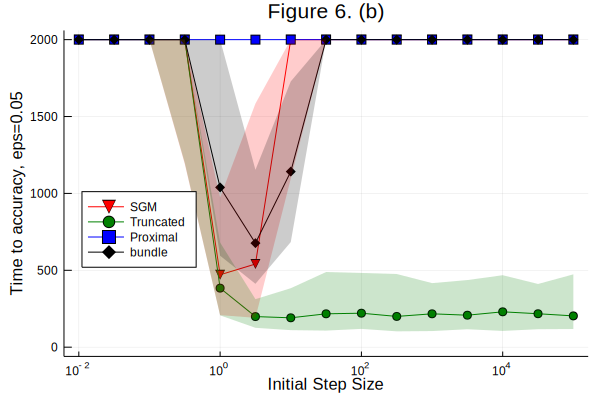

In [26]:
plt = plot(γinits, [sgm_iters[:,2] trunc_iters[:, 2] prox_iters[:, 2] bund_iters[:, 2]], 
    legend = :left,
    xscale = :log10,
    xlab = "Initial Step Size",
    ylab = "Time to accuracy, eps=0.05",
    title = "Figure 6. (b)",
    label = ["SGM" "Truncated" "Proximal" "bundle"],
    color = [:red :green :blue :black],
    markershape = [:dtriangle :circle :square :diamond],
    ylim = [0, nitr])
a = Shape([γinits; γinits[end:-1:2]],
    [sgm_iters[:,1]; sgm_iters[end:-1:2,3]])
plot!(a, fillalpha = 0.2, linecolor = nothing, fillcolor = :red, label = "")
b = Shape([γinits; γinits[end:-1:2]],
    [trunc_iters[:,1]; trunc_iters[end:-1:2,3]])
plot!(b, fillalpha = 0.2, linecolor = nothing, fillcolor = :green, label = "")
c = Shape([γinits; γinits[end:-1:2]],
    [prox_iters[:,1]; prox_iters[end:-1:2,3]])
plot!(c, fillalpha = 0.2, linecolor = nothing, fillcolor = :blue, label = "")
d = Shape([γinits; γinits[end-1:-1:2]],
    [bund_iters[:,1]; bund_iters[end-1:-1:2,3]])
plot!(d, fillalpha = 0.2, linecolor = nothing, fillcolor = :black, label = "")